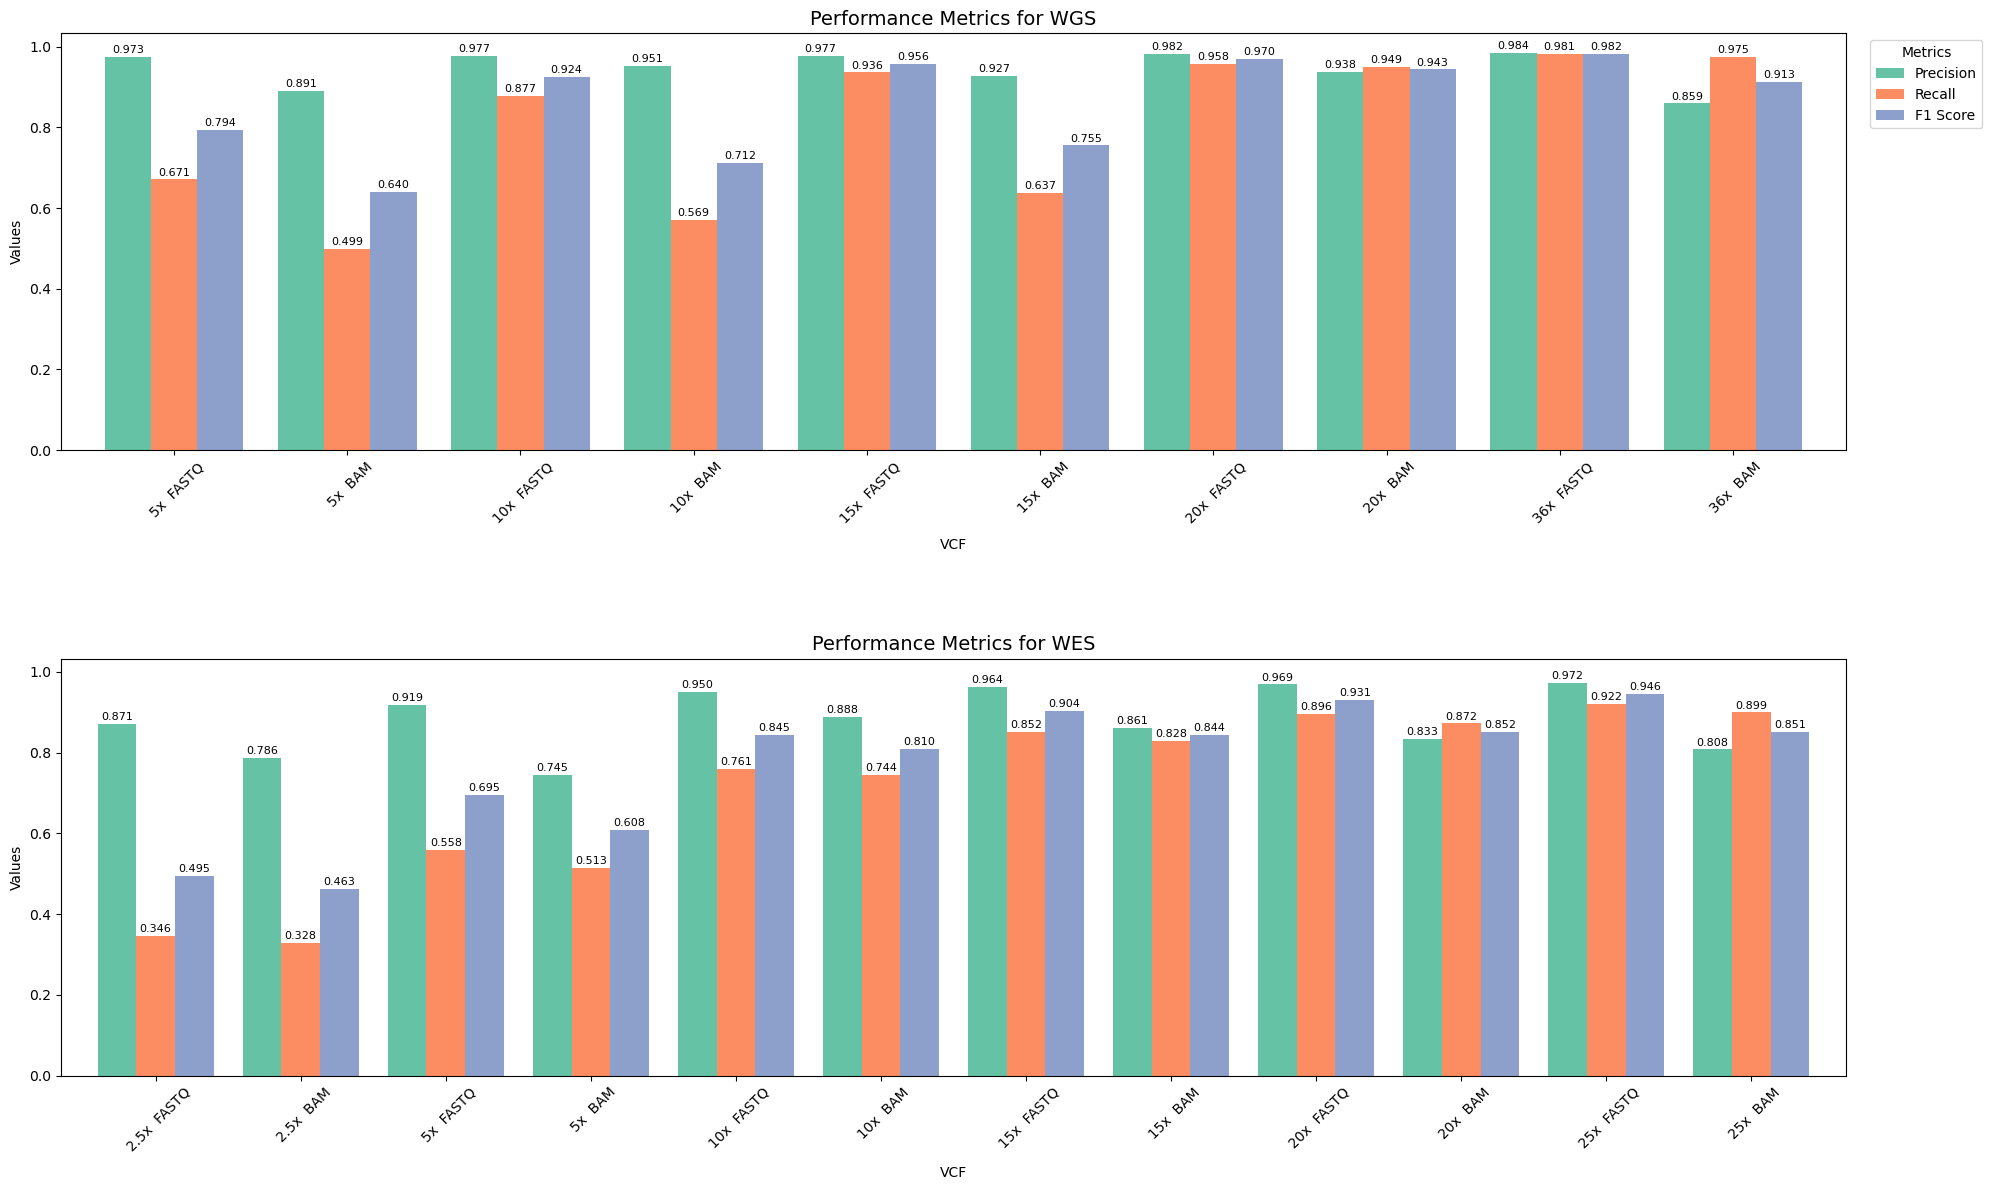

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from cyvcf2 import VCF

# Store reference files and sample VCFs for normals and difficultregions
datasets = {
    'normals': {
        'reference': 'wgs_HG002_GRCh38_1_22_v4.2.1_benchmark.vcf',
        'vcf_files': [
            'wgs_5xdepth_FASTQ.vcf', 'wgs_5xdepth_BAM.vcf',
            'wgs_10xdepth_FASTQ.vcf', 'wgs_10xdepth_BAM.vcf',
            'wgs_15xdepth_FASTQ.vcf', 'wgs_15xdepth_BAM.vcf',
            'wgs_20xdepth_FASTQ.vcf', 'wgs_20xdepth_BAM.vcf',
            'wgs_36xdepth_FASTQ.vcf', 'wgs_36xdepth_BAM.vcf',
            'wgs_HG002_GRCh38_1_22_v4.2.1_benchmark.vcf'  # Will be removed from plot later
        ]
    },
    'difficultregions': {
        'reference': 'wes_HG002_GRCh38_1_22_filtered.vcf',
        'vcf_files': [
            'wes_2.5xdepth_FASTQ.vcf', 'wes_2.5xdepth_BAM.vcf',
            'wes_5xdepth_FASTQ.vcf', 'wes_5xdepth_BAM.vcf',
            'wes_10xdepth_FASTQ.vcf', 'wes_10xdepth_BAM.vcf',
            'wes_15xdepth_FASTQ.vcf', 'wes_15xdepth_BAM.vcf',
            'wes_20xdepth_FASTQ.vcf', 'wes_20xdepth_BAM.vcf',
            'wes_25xdepth_FASTQ.vcf', 'wes_25xdepth_BAM.vcf',
            'wes_HG002_GRCh38_1_22_filtered.vcf'  # Will be removed from plot later
        ]
    }
}

# Container for results
all_metrics = []

# Process both normals and difficultregions
for variant_type, data in datasets.items():
    vcf_reference = VCF(data['reference'])
    variants_ref = set((v.CHROM, v.POS, v.REF, tuple(v.ALT)) for v in vcf_reference)

    for vcf_file in data['vcf_files']:
        if vcf_file == data['reference']:  # Skip plotting reference
            continue

        vcf = VCF(vcf_file)
        variants_sample = set((v.CHROM, v.POS, v.REF, tuple(v.ALT)) for v in vcf)

        true_positive = len(variants_sample & variants_ref)
        false_positive = len(variants_sample - variants_ref)
        false_negative = len(variants_ref - variants_sample)

        precision = true_positive / (true_positive + false_positive) if (true_positive + false_positive) > 0 else 0
        recall = true_positive / (true_positive + false_negative) if (true_positive + false_negative) > 0 else 0
        f1_score = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

        all_metrics.append({
            'VCF': vcf_file,
            'Precision': precision,
            'Recall': recall,
            'F1 Score': f1_score,
            'Total Variants': true_positive + false_positive,
            'Type': variant_type
        })

# Convert to Pandas for plotting
df = pd.DataFrame(all_metrics)

# Simplify labels
def simplify_label(filename):
    return filename.replace('.vcf', '').replace('_difficultregions', '') \
                   .replace('depth', '').replace('x', 'x ').replace('_', ' ').replace('wgs', ' ').replace('wes', ' ') 
df['VCF'] = df['VCF'].apply(simplify_label)

# Split by type
df_normals = df[df['Type'] == 'normals'].copy()
df_difficultregions = df[df['Type'] == 'difficultregions'].copy()

# Reset index for plotting
df_normals.reset_index(drop=True, inplace=True)
df_difficultregions.reset_index(drop=True, inplace=True)

# Create vertically stacked plots
fig, axes = plt.subplots(2, 1, figsize=(20, 12), sharey=True)

# Define colors matching Seaborn's Set2 for consistency
custom_colors = ['#66c2a5', '#fc8d62', '#8da0cb']

# normals plot
ax1 = df_normals[['VCF', 'Precision', 'Recall', 'F1 Score']].plot(
    kind='bar', x='VCF', ax=axes[0], width=0.8, color=custom_colors
)
ax1.set_title('Performance Metrics for WGS', fontsize=14)
ax1.set_ylabel('Values')
ax1.tick_params(axis='x', rotation=45)
ax1.legend(title='Metrics', bbox_to_anchor=(1.01, 1), loc='upper left')

for p in ax1.patches:
    if p.get_height() > 0:
        ax1.annotate(f'{p.get_height():.3f}',
                     (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha='center', va='center', xytext=(0, 5),
                     textcoords='offset points', fontsize=8)

# difficultregions plot
ax2 = df_difficultregions[['VCF', 'Precision', 'Recall', 'F1 Score']].plot(
    kind='bar', x='VCF', ax=axes[1], width=0.8, color=custom_colors, legend=False
)
ax2.set_title('Performance Metrics for WES', fontsize=14)
ax2.set_ylabel('Values')
ax2.tick_params(axis='x', rotation=45)

for p in ax2.patches:
    if p.get_height() > 0:
        ax2.annotate(f'{p.get_height():.3f}',
                     (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha='center', va='center', xytext=(0, 5),
                     textcoords='offset points', fontsize=8)


plt.tight_layout()

plt.subplots_adjust(hspace=0.5)  # Increase the value for more spacing

# Save high-res version
plt.savefig("High Confidence.png", dpi=300)  # or use SVG if preferred
plt.show()


In [5]:
for variant_type, data in datasets.items():
    for vcf_file in data['vcf_files']:
        try:
            vcf = VCF(vcf_file)
            variant_count = sum(1 for _ in vcf)
            print(f"{vcf_file}: {variant_count}")
        except Exception as e:
            print(f"Error reading {vcf_file}: {e}")
    print()  # Blank line for spacing


wgs_5xdepth_FASTQ.vcf: 2681236
wgs_5xdepth_BAM.vcf: 2181774
wgs_10xdepth_FASTQ.vcf: 3492820
wgs_10xdepth_BAM.vcf: 2329912
wgs_15xdepth_FASTQ.vcf: 3725286
wgs_15xdepth_BAM.vcf: 2674795
wgs_20xdepth_FASTQ.vcf: 3794068
wgs_20xdepth_BAM.vcf: 3936692
wgs_36xdepth_FASTQ.vcf: 3878526
wgs_36xdepth_BAM.vcf: 4416292
wgs_HG002_GRCh38_1_22_v4.2.1_benchmark.vcf: 3890782

wes_2.5xdepth_FASTQ.vcf: 16404
wes_2.5xdepth_BAM.vcf: 17261
wes_5xdepth_FASTQ.vcf: 25122
wes_5xdepth_BAM.vcf: 28478
wes_10xdepth_FASTQ.vcf: 33113
wes_10xdepth_BAM.vcf: 34639
wes_15xdepth_FASTQ.vcf: 36544
wes_15xdepth_BAM.vcf: 39780
wes_20xdepth_FASTQ.vcf: 38244
wes_20xdepth_BAM.vcf: 43295
wes_25xdepth_FASTQ.vcf: 39200
wes_25xdepth_BAM.vcf: 46043
wes_HG002_GRCh38_1_22_filtered.vcf: 41351



In [ ]:
# Print total variant counts for each VCF, including reference files
print("Total Variant Counts (including reference files):\n")

for variant_type, data in datasets.items():
    print(f"=== {variant_type.upper()} ===")
    for vcf_file in data['vcf_files']:
        try:
            vcf = VCF(vcf_file)
            variant_count = sum(1 for _ in vcf)
            print(f"{vcf_file}: {variant_count} variants")
        except Exception as e:
            print(f"Error reading {vcf_file}: {e}")
    print()  # Blank line for spacing


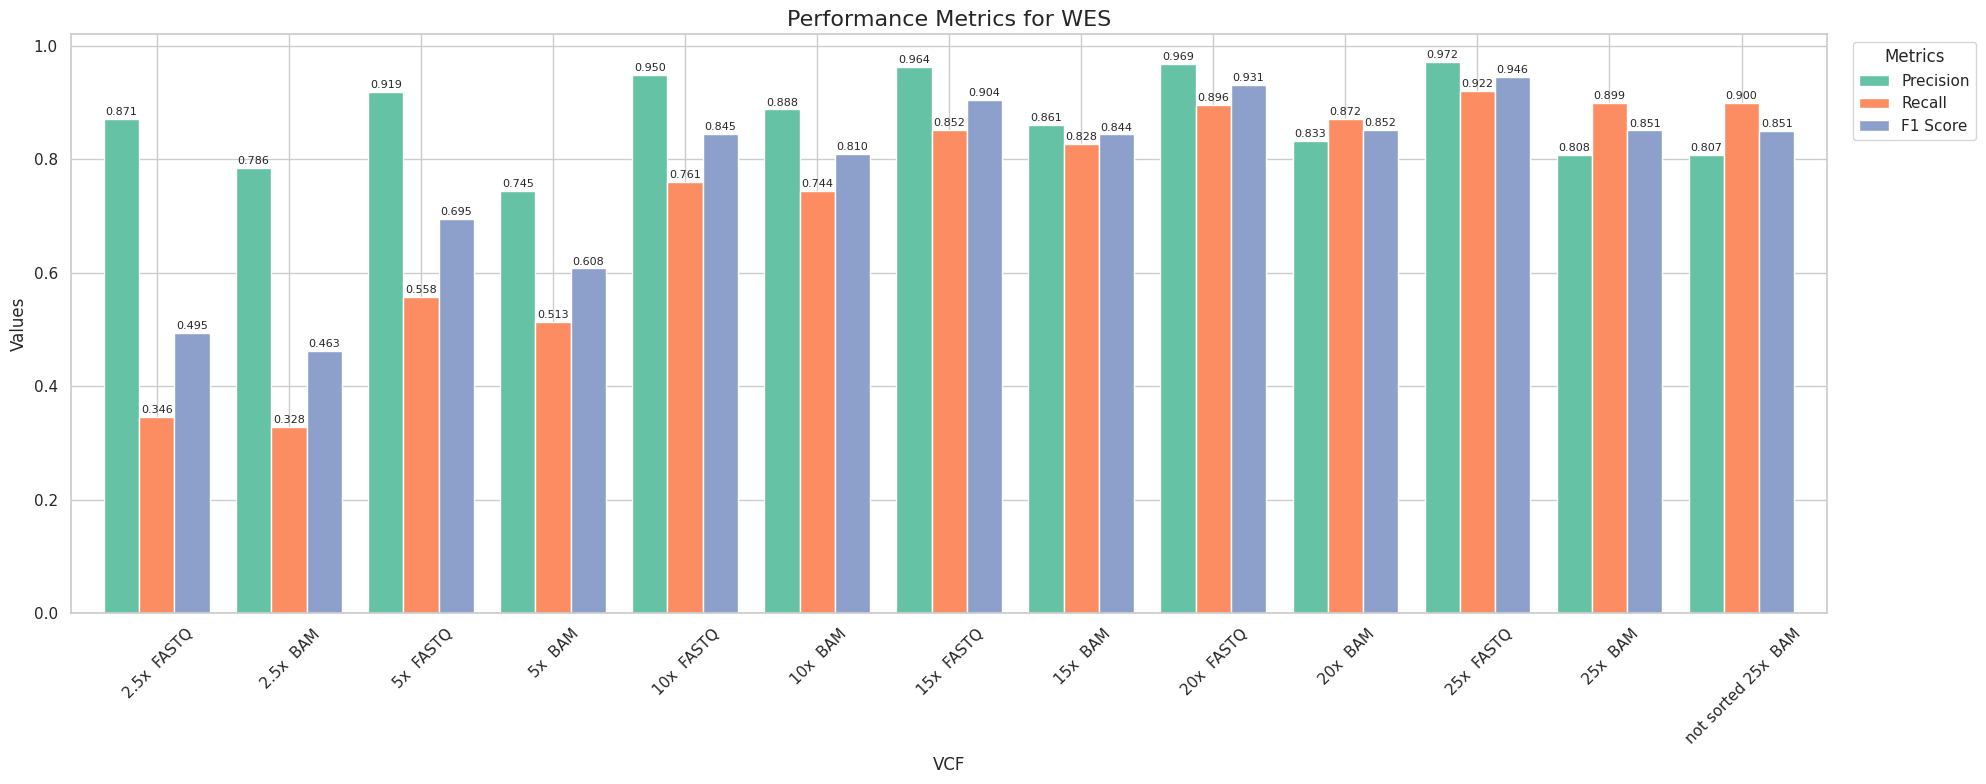

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from cyvcf2 import VCF

# Store reference files and sample VCFs for normals and difficultregions
datasets = {
    'normals': {
        'reference': 'wes_HG002_GRCh38_1_22_filtered.vcf',
        'vcf_files': [
            'wes_2.5xdepth_FASTQ.vcf', 'wes_2.5xdepth_BAM.vcf',
            'wes_5xdepth_FASTQ.vcf', 'wes_5xdepth_BAM.vcf',
            'wes_10xdepth_FASTQ.vcf', 'wes_10xdepth_BAM.vcf',
            'wes_15xdepth_FASTQ.vcf', 'wes_15xdepth_BAM.vcf',
            'wes_20xdepth_FASTQ.vcf', 'wes_20xdepth_BAM.vcf',
            'wes_25xdepth_FASTQ.vcf', 'wes_25xdepth_BAM.vcf',
            'wes_not_sorted_25x_BAM.vcf',
            'wes_HG002_GRCh38_1_22_filtered.vcf'  # Will be removed from plot later
        ]
    }
}

# Container for results
all_metrics = []

# Process both normals and difficultregions
for variant_type, data in datasets.items():
    vcf_reference = VCF(data['reference'])
    variants_ref = set((v.CHROM, v.POS, v.REF, tuple(v.ALT)) for v in vcf_reference)

    for vcf_file in data['vcf_files']:
        if vcf_file == data['reference']:  # Skip plotting reference
            continue

        vcf = VCF(vcf_file)
        variants_sample = set((v.CHROM, v.POS, v.REF, tuple(v.ALT)) for v in vcf)

        true_positive = len(variants_sample & variants_ref)
        false_positive = len(variants_sample - variants_ref)
        false_negative = len(variants_ref - variants_sample)

        precision = true_positive / (true_positive + false_positive) if (true_positive + false_positive) > 0 else 0
        recall = true_positive / (true_positive + false_negative) if (true_positive + false_negative) > 0 else 0
        f1_score = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

        all_metrics.append({
            'VCF': vcf_file,
            'Precision': precision,
            'Recall': recall,
            'F1 Score': f1_score,
            'Total Variants': true_positive + false_positive,
            'Type': variant_type
        })

# Convert to Pandas for plotting
df = pd.DataFrame(all_metrics)

# Simplify labels
def simplify_label(filename):
    return filename.replace('.vcf', '').replace('_difficultregions', '') \
                   .replace('depth', '').replace('x', 'x ').replace('_', ' ').replace('wes', '')

df['VCF'] = df['VCF'].apply(simplify_label)

# Split by type
df_normals = df[df['Type'] == 'normals'].copy()

# Reset index for plotting
df_normals.reset_index(drop=True, inplace=True)

# Create a single plot (no subplots)
fig, ax = plt.subplots(figsize=(20, 8))  # Only one axes object now

# Define consistent colors matching Seaborn's Set2 palette
custom_colors = ['#66c2a5', '#fc8d62', '#8da0cb']  # Precision, Recall, F1 Score

# Plot the metrics with custom colors
df_normals[['VCF', 'Precision', 'Recall', 'F1 Score']].plot(
    kind='bar', x='VCF', ax=ax, width=0.8, color=custom_colors
)

# Title and labels
ax.set_title('Performance Metrics for WES', fontsize=16)
ax.set_ylabel('Values')
ax.tick_params(axis='x', rotation=45)
ax.legend(title='Metrics', bbox_to_anchor=(1.01, 1), loc='upper left')

# Annotate bars
for p in ax.patches:
    if p.get_height() > 0:
        ax.annotate(f'{p.get_height():.3f}',
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', xytext=(0, 5),
                    textcoords='offset points', fontsize=8)


plt.tight_layout()
plt.savefig("WESnormalandpresorted.png", dpi=300)
plt.show()


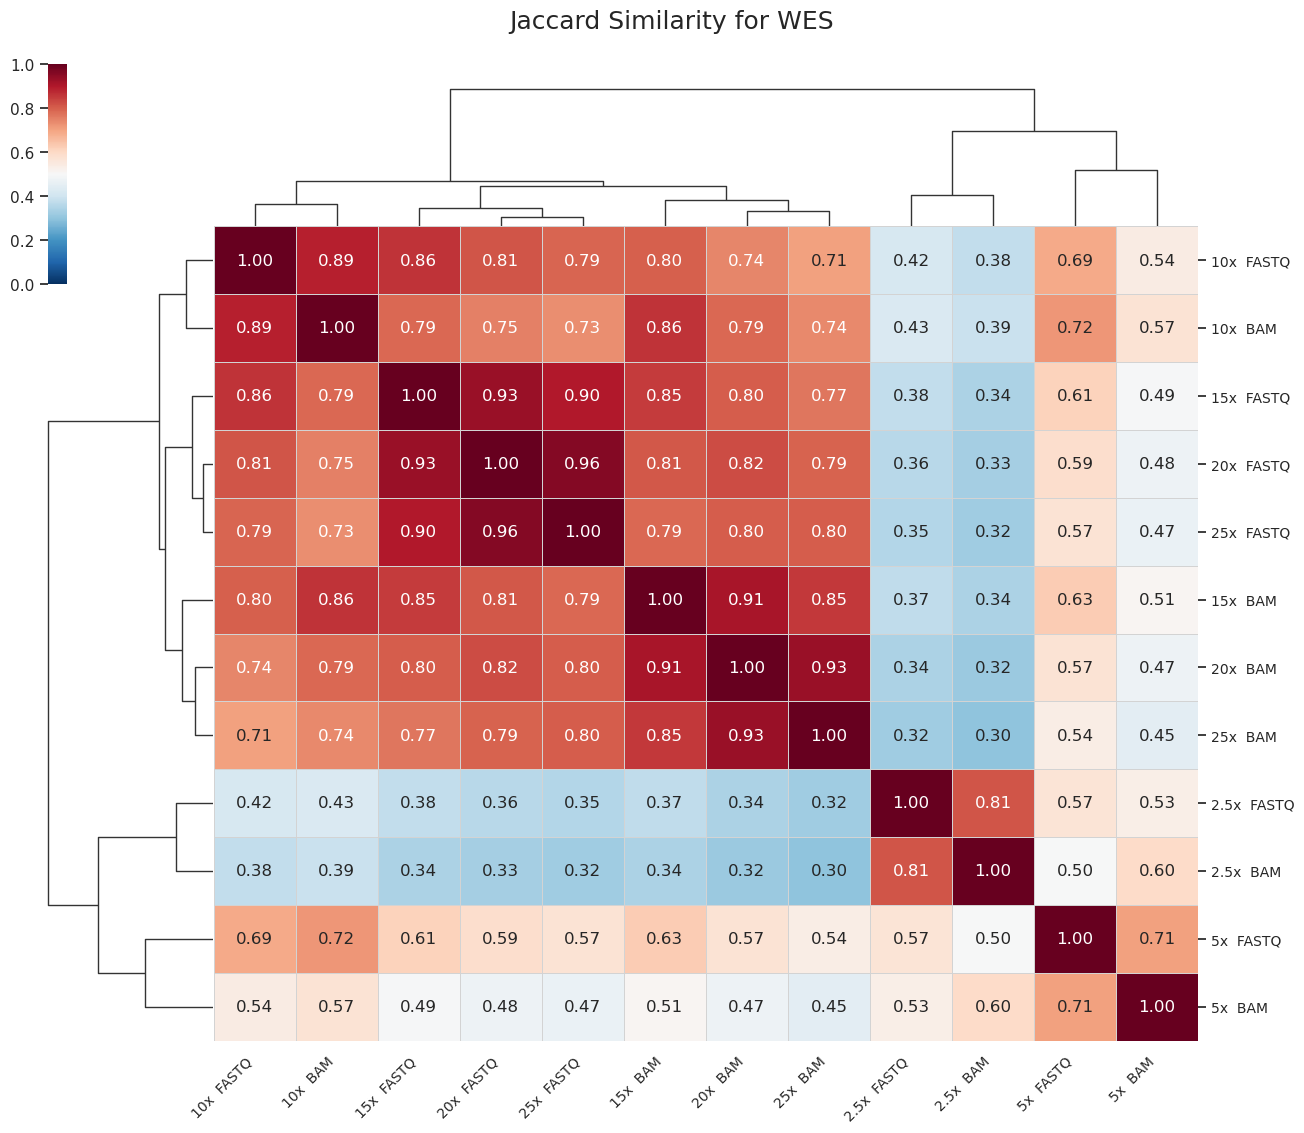

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from cyvcf2 import VCF
import scipy.cluster.hierarchy as sch

# === CONFIGURATION ===
reference_vcf = 'wes_HG002_GRCh38_1_22_filtered.vcf'
vcf_files = [
    'wes_2.5xdepth_FASTQ.vcf', 'wes_2.5xdepth_BAM.vcf',
    'wes_5xdepth_FASTQ.vcf', 'wes_5xdepth_BAM.vcf',
    'wes_10xdepth_FASTQ.vcf', 'wes_10xdepth_BAM.vcf',
    'wes_15xdepth_FASTQ.vcf', 'wes_15xdepth_BAM.vcf',
    'wes_20xdepth_FASTQ.vcf', 'wes_20xdepth_BAM.vcf',
    'wes_25xdepth_FASTQ.vcf', 'wes_25xdepth_BAM.vcf'
]

# === METRIC CALCULATION ===
ref_variants = set((v.CHROM, v.POS, v.REF, tuple(v.ALT)) for v in VCF(reference_vcf))
metrics = []

for file in vcf_files:
    sample_variants = set((v.CHROM, v.POS, v.REF, tuple(v.ALT)) for v in VCF(file))
    tp = len(sample_variants & ref_variants)
    fp = len(sample_variants - ref_variants)
    fn = len(ref_variants - sample_variants)

    precision = tp / (tp + fp) if tp + fp > 0 else 0
    recall = tp / (tp + fn) if tp + fn > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if precision + recall > 0 else 0

    metrics.append({
        'VCF': file,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'Total Variants': tp + fp
    })

df_metrics = pd.DataFrame(metrics)

# === JACCARD SIMILARITY MATRIX ===
unique_variants = set()
for file in vcf_files:
    for v in VCF(file):
        unique_variants.add((v.CHROM, v.POS, v.REF, tuple(v.ALT)))
unique_variants = sorted(unique_variants, key=lambda x: (x[0], x[1]))

variant_matrix = np.zeros((len(vcf_files), len(unique_variants)), dtype=int)
for i, file in enumerate(vcf_files):
    sample_variants = {(v.CHROM, v.POS, v.REF, tuple(v.ALT)) for v in VCF(file)}
    for j, variant in enumerate(unique_variants):
        if variant in sample_variants:
            variant_matrix[i][j] = 1

intersect = np.dot(variant_matrix, variant_matrix.T)
row_sums = variant_matrix.sum(axis=1, keepdims=True)
union = row_sums + row_sums.T - intersect
jaccard_sim = intersect / np.where(union == 0, 1, union)

# === LABELS ===
def clean_label(name):
    return (name.replace('.vcf', '')
                .replace('wes_', '')
                .replace('depth', '')
                .replace('x', 'x ')
                .replace('_', ' ')
                .strip())

pipeline_labels = [clean_label(f) for f in vcf_files]
df_jaccard = pd.DataFrame(jaccard_sim, index=pipeline_labels, columns=pipeline_labels)

# === DENDROGRAMS ===
row_linkage = sch.linkage(jaccard_sim, method='average')
col_linkage = sch.linkage(jaccard_sim.T, method='average')

# === CLUSTERMAP ===
sns.set(style="whitegrid")
g = sns.clustermap(
    df_jaccard,
    row_linkage=row_linkage,
    col_linkage=col_linkage,
    row_cluster=True,
    col_cluster=True,
    cmap="RdBu_r",
    annot=True,
    fmt=".2f",
    vmin=0,
    vmax=1,
    linewidths=0.5,
    linecolor='lightgray',
    cbar_kws={"shrink": 0.75, "location": "left"},
    cbar_pos=(0.02, 0.8, 0.015, 0.2),  # moved up and kept thin
    figsize=(13, 11),
    xticklabels=True,
    yticklabels=True,
    dendrogram_ratio=(0.15, 0.15),
    tree_kws={"linewidth": 1}
)


# === TITLE ===
g.fig.suptitle("Jaccard Similarity for WES", fontsize=18, y=1.05)

# === TICKS ===
plt.setp(g.ax_heatmap.get_xticklabels(), rotation=45, ha='right', fontsize=10)
plt.setp(g.ax_heatmap.get_yticklabels(), fontsize=10)

# === SAVE ===
plt.savefig("WES_Jaccard_Similarity_for_WES.png", dpi=300)
plt.show()



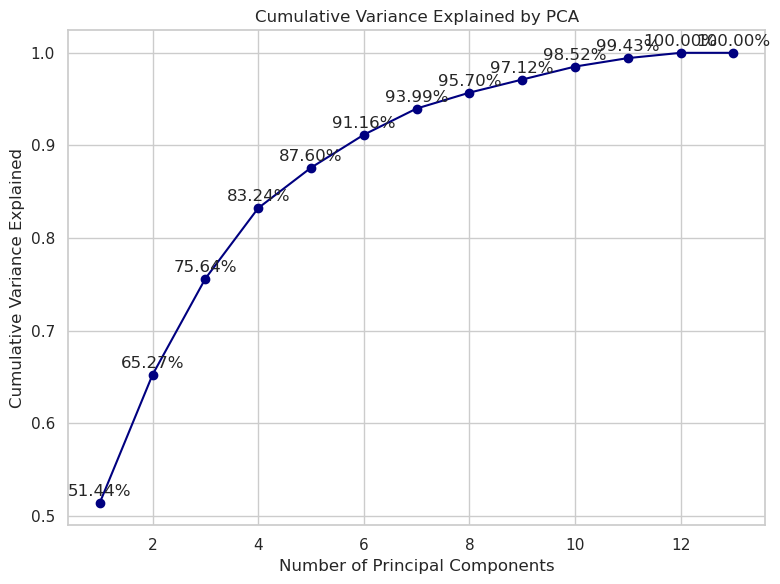

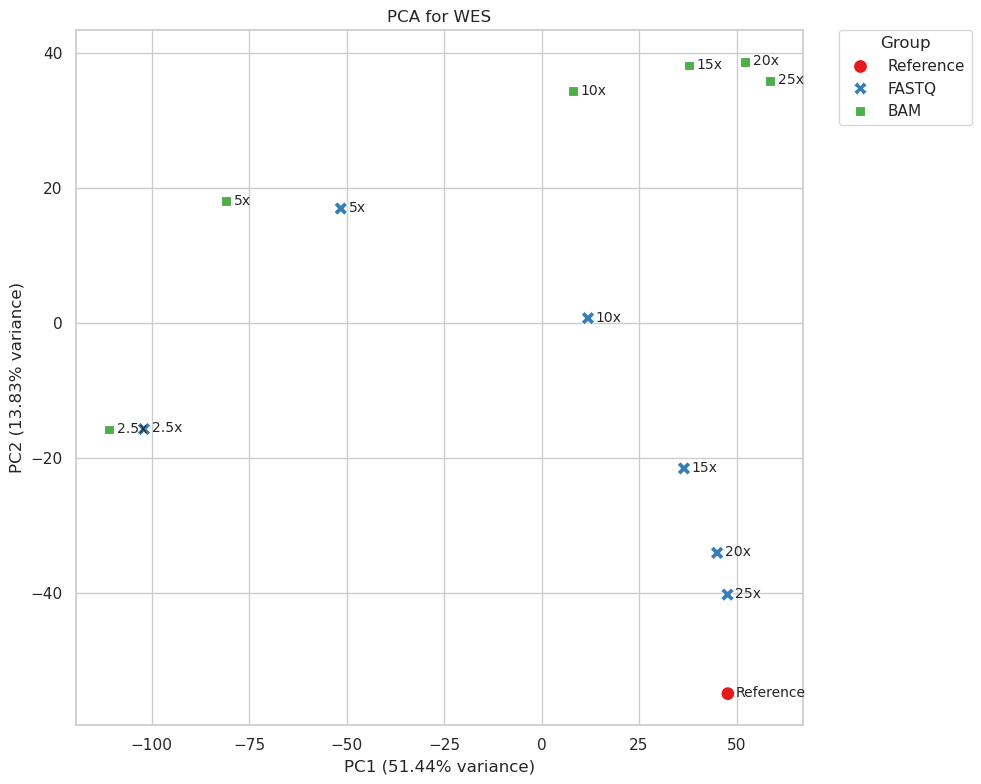

In [6]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from cyvcf2 import VCF

# === INCLUDE REFERENCE VCF IN ANALYSIS ===
all_vcfs = [reference_vcf] + vcf_files  # 13 files including reference

# === COLLECT ALL UNIQUE VARIANTS ===
unique_variants = set()
for file in all_vcfs:
    for v in VCF(file):
        unique_variants.add((v.CHROM, v.POS, v.REF, tuple(v.ALT)))
unique_variants = sorted(unique_variants, key=lambda x: (x[0], x[1]))

# === BUILD VARIANT PRESENCE/ABSENCE MATRIX ===
variant_matrix = np.zeros((len(all_vcfs), len(unique_variants)), dtype=int)
for i, file in enumerate(all_vcfs):
    sample_variants = {(v.CHROM, v.POS, v.REF, tuple(v.ALT)) for v in VCF(file)}
    for j, variant in enumerate(unique_variants):
        if variant in sample_variants:
            variant_matrix[i][j] = 1

# === PCA COMPUTATION ===
pca = PCA()
pca_result = pca.fit_transform(variant_matrix)
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

# === PLOT CUMULATIVE VARIANCE ===
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio, marker='o', linestyle='-', color='navy')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Variance Explained')
plt.title('Cumulative Variance Explained by PCA')
for i, val in enumerate(cumulative_variance_ratio):
    plt.annotate(f'{val*100:.2f}%', (i+1, val), textcoords="offset points", xytext=(0, 5), ha='center')
plt.tight_layout()
plt.savefig("PCA_Cumulative_Variance_WES_with_REF.png", dpi=300)
plt.show()

# === REDUCE TO 2 COMPONENTS FOR SCATTER PLOT ===
pca_2d = PCA(n_components=2)
reduced = pca_2d.fit_transform(variant_matrix)

# === LABELS AND GROUPING ===
def simplify_name(name):
    if "HG002" in name:
        return "Reference"
    else:
        label = name.replace(".vcf", "").replace("wes_", "").replace("depth", "").replace("x", "x ").replace("_", " ")
        return label.replace("FASTQ", "").replace("BAM", "").strip()

def classify_pipeline(name):
    if "HG002" in name:
        return "Reference"
    elif "FASTQ" in name:
        return "FASTQ"
    elif "BAM" in name:
        return "BAM"
    else:
        return "Other"

labels = [simplify_name(f) for f in all_vcfs]
groups = [classify_pipeline(f) for f in all_vcfs]

# === CREATE DATAFRAME FOR PLOTTING ===
pca_df = pd.DataFrame(reduced, columns=["PC1", "PC2"])
pca_df["Label"] = labels
pca_df["Group"] = groups

# === SCATTER PLOT OF PCA ===
plt.figure(figsize=(10, 8))
sns.scatterplot(
    data=pca_df,
    x="PC1", y="PC2",
    hue="Group",
    style="Group",
    s=100,
    palette="Set1"
)

# Add labels to each point
for _, row in pca_df.iterrows():
    plt.text(row["PC1"] + 2.0, row["PC2"] - 0.5, row["Label"], fontsize=10, ha='left')

plt.xlabel(f"PC1 ({explained_variance_ratio[0]:.2%} variance)")
plt.ylabel(f"PC2 ({explained_variance_ratio[1]:.2%} variance)")
plt.title("PCA for WES")

# Legend outside
plt.legend(
    title='Group',
    bbox_to_anchor=(1.05, 1),
    loc='upper left',
    borderaxespad=0.
)

plt.tight_layout()
plt.savefig("PCA_Scatter_WES_with_REF_CleanLabels.png", dpi=300)
plt.show()


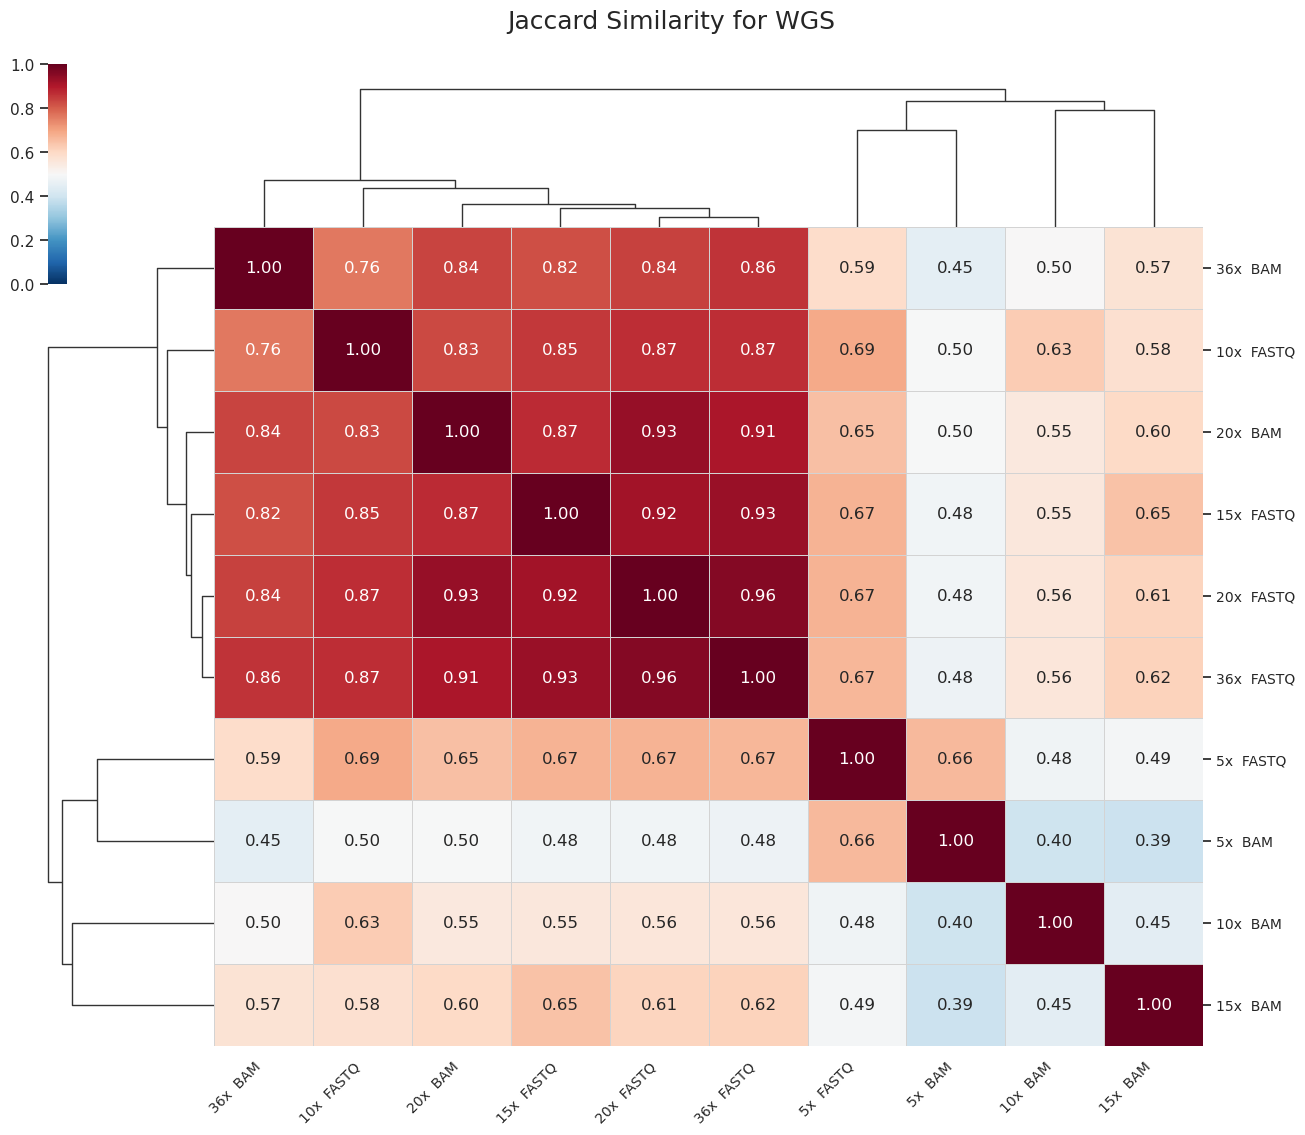

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from cyvcf2 import VCF

# Store reference files and sample VCFs for normals and difficultregions

reference_vcf = 'wgs_HG002_GRCh38_1_22_v4.2.1_benchmark.vcf'
vcf_files = [
            'wgs_5xdepth_FASTQ.vcf', 'wgs_5xdepth_BAM.vcf',
            'wgs_10xdepth_FASTQ.vcf', 'wgs_10xdepth_BAM.vcf',
            'wgs_15xdepth_FASTQ.vcf', 'wgs_15xdepth_BAM.vcf',
            'wgs_20xdepth_FASTQ.vcf', 'wgs_20xdepth_BAM.vcf',
            'wgs_36xdepth_FASTQ.vcf', 'wgs_36xdepth_BAM.vcf',
        ]
   
# === METRIC CALCULATION ===
ref_variants = set((v.CHROM, v.POS, v.REF, tuple(v.ALT)) for v in VCF(reference_vcf))
metrics = []

for file in vcf_files:
    sample_variants = set((v.CHROM, v.POS, v.REF, tuple(v.ALT)) for v in VCF(file))
    tp = len(sample_variants & ref_variants)
    fp = len(sample_variants - ref_variants)
    fn = len(ref_variants - sample_variants)

    precision = tp / (tp + fp) if tp + fp > 0 else 0
    recall = tp / (tp + fn) if tp + fn > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if precision + recall > 0 else 0

    metrics.append({
        'VCF': file,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'Total Variants': tp + fp
    })

df_metrics = pd.DataFrame(metrics)

# === JACCARD SIMILARITY MATRIX ===
unique_variants = set()
for file in vcf_files:
    for v in VCF(file):
        unique_variants.add((v.CHROM, v.POS, v.REF, tuple(v.ALT)))
unique_variants = sorted(unique_variants, key=lambda x: (x[0], x[1]))

variant_matrix = np.zeros((len(vcf_files), len(unique_variants)), dtype=int)
for i, file in enumerate(vcf_files):
    sample_variants = {(v.CHROM, v.POS, v.REF, tuple(v.ALT)) for v in VCF(file)}
    for j, variant in enumerate(unique_variants):
        if variant in sample_variants:
            variant_matrix[i][j] = 1

intersect = np.dot(variant_matrix, variant_matrix.T)
row_sums = variant_matrix.sum(axis=1, keepdims=True)
union = row_sums + row_sums.T - intersect
jaccard_sim = intersect / np.where(union == 0, 1, union)

# === LABELS ===
def clean_label(name):
    return (name.replace('.vcf', '')
                .replace('wgs_', '')
                .replace('depth', '')
                .replace('x', 'x ')
                .replace('_', ' ')
                .strip())

pipeline_labels = [clean_label(f) for f in vcf_files]
df_jaccard = pd.DataFrame(jaccard_sim, index=pipeline_labels, columns=pipeline_labels)

# === DENDROGRAMS ===
row_linkage = sch.linkage(jaccard_sim, method='average')
col_linkage = sch.linkage(jaccard_sim.T, method='average')

# === CLUSTERMAP ===
sns.set(style="whitegrid")
g = sns.clustermap(
    df_jaccard,
    row_linkage=row_linkage,
    col_linkage=col_linkage,
    row_cluster=True,
    col_cluster=True,
    cmap="RdBu_r",
    annot=True,
    fmt=".2f",
    vmin=0,
    vmax=1,
    linewidths=0.5,
    linecolor='lightgray',
    cbar_kws={"shrink": 0.75, "location": "left"},
    cbar_pos=(0.02, 0.8, 0.015, 0.2),  # moved up and kept thin
    figsize=(13, 11),
    xticklabels=True,
    yticklabels=True,
    dendrogram_ratio=(0.15, 0.15),
    tree_kws={"linewidth": 1}
)


# === TITLE ===
g.fig.suptitle("Jaccard Similarity for WGS", fontsize=18, y=1.05)

# === TICKS ===
plt.setp(g.ax_heatmap.get_xticklabels(), rotation=45, ha='right', fontsize=10)
plt.setp(g.ax_heatmap.get_yticklabels(), fontsize=10)

# === SAVE ===
plt.savefig("WES_Jaccard_Similarity_for_WGS.png", dpi=300)
plt.show()


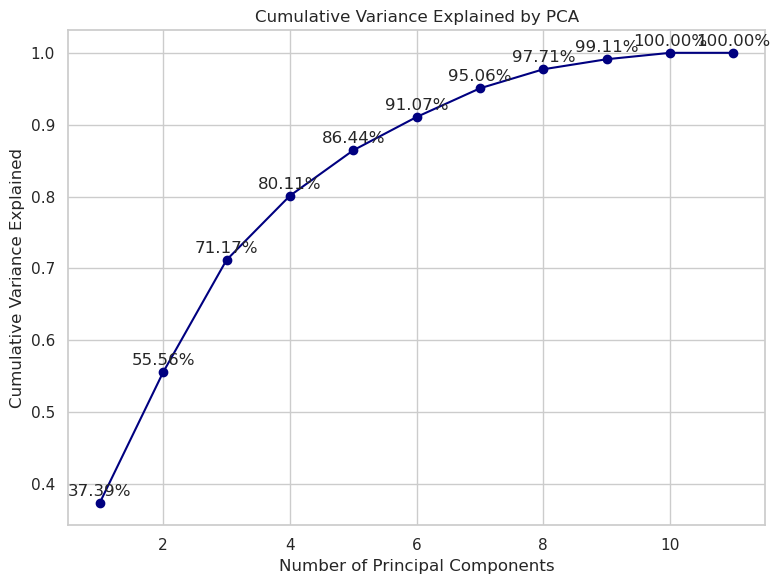

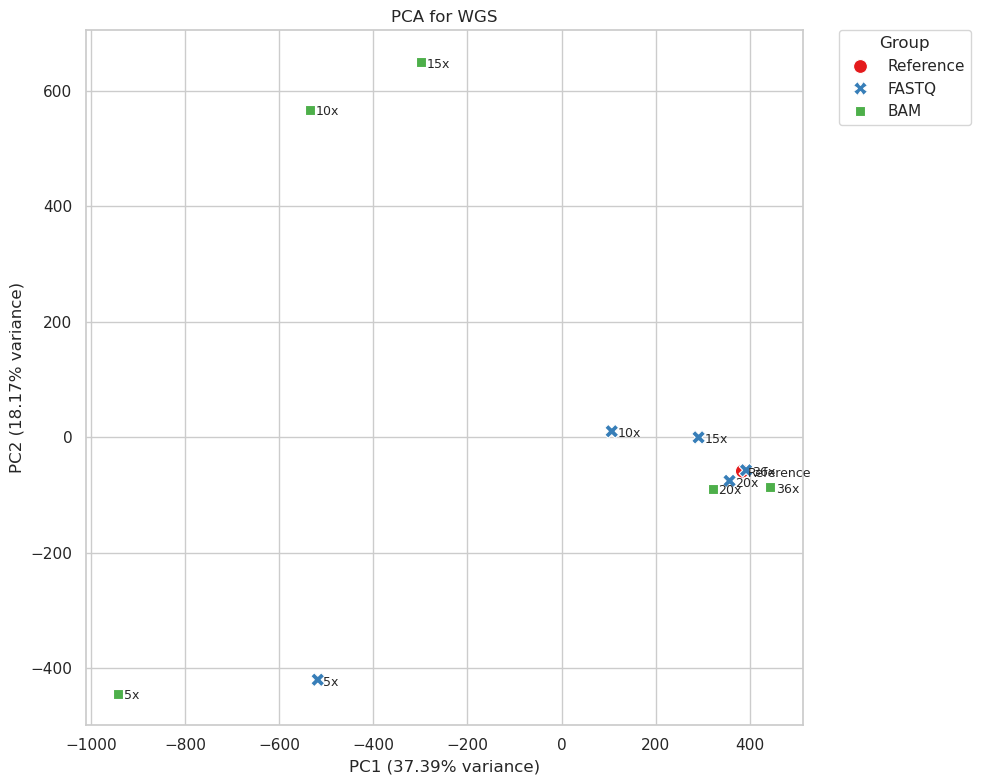

In [10]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from cyvcf2 import VCF



# === PLOT CUMULATIVE VARIANCE ===
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio, marker='o', linestyle='-', color='navy')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Variance Explained')
plt.title('Cumulative Variance Explained by PCA')
for i, val in enumerate(cumulative_variance_ratio):
    plt.annotate(f'{val*100:.2f}%', (i+1, val), textcoords="offset points", xytext=(0, 5), ha='center')
plt.tight_layout()
plt.savefig("PCA_Cumulative_Variance_WES_with_REF.png", dpi=300)
plt.show()

# === REDUCE TO 2 COMPONENTS FOR SCATTER PLOT ===
pca_2d = PCA(n_components=2)
reduced = pca_2d.fit_transform(variant_matrix)

# === LABELS AND GROUPING ===
def simplify_name(name):
    if "HG002" in name:
        return "Reference"
    else:
        label = name.replace(".vcf", "").replace("wgs_", "").replace("depth", "").replace("x", "x ").replace("_", " ")
        return label.replace("FASTQ", "").replace("BAM", "").strip()

def classify_pipeline(name):
    if "HG002" in name:
        return "Reference"
    elif "FASTQ" in name:
        return "FASTQ"
    elif "BAM" in name:
        return "BAM"
    else:
        return "Other"

labels = [simplify_name(f) for f in all_vcfs]
groups = [classify_pipeline(f) for f in all_vcfs]

# === CREATE DATAFRAME FOR PLOTTING ===
pca_df = pd.DataFrame(reduced, columns=["PC1", "PC2"])
pca_df["Label"] = labels
pca_df["Group"] = groups

# === SCATTER PLOT OF PCA ===
plt.figure(figsize=(10, 8))
sns.scatterplot(
    data=pca_df,
    x="PC1", y="PC2",
    hue="Group",
    style="Group",
    s=100,
    palette="Set1"
)

# Add labels to each point
for i, row in pca_df.iterrows():
    plt.text(row['PC1'] + 12, row['PC2'] - 10.0, row['Label'], fontsize=9)
    
plt.xlabel(f"PC1 ({explained_variance_ratio[0]:.2%} variance)")
plt.ylabel(f"PC2 ({explained_variance_ratio[1]:.2%} variance)")
plt.title("PCA for WGS")

# Legend outside
plt.legend(
    title='Group',
    bbox_to_anchor=(1.05, 1),
    loc='upper left',
    borderaxespad=0.
)

plt.tight_layout()
plt.savefig("PCA_Scatter_WES_with_REF_CleanLabels.png", dpi=300)
plt.show()
